# Integrated Housing Price Prediction Models — Main Notebook

## Overview
This notebook combines **five different machine learning models** to predict house prices using the Ames Housing dataset:

- **Linear Regression**
- **Polynomial Regression**
- **MLP (Neural Network)**
- **XGBoost (Paper-inspired pipeline)**
- **CatBoost (Paper-inspired pipeline)**

Each model is trained on the same train/test split so performance can be compared fairly.

## What This Notebook Does
- Loads and preprocesses the Ames Housing dataset  
- Implements **5 full regression pipelines**  
- Evaluates every model using:
  - **MAE**
  - **MSE**
  - **RMSE**
  - **R² Score**
- Summarizes all results into a **comparison table**
- Identifies the **best model** based on test performance  

## Purpose
This notebook serves as a **complete comparison framework**, showing how classical models, neural models, and research-paper-inspired models perform on the same dataset.

---

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from catboost import CatBoostRegressor, Pool

In [74]:
df = pd.read_csv("data/train.csv")

print("Full dataset shape:", df.shape)
df.head()

Full dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [75]:
target_col = "SalePrice"

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1168, 80)
X_test shape: (292, 80)


In [76]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

def print_metrics(name, y_train_true, y_train_pred, y_test_true, y_test_pred):
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_mse = mean_squared_error(y_train_true, y_train_pred)
    train_rmse = train_mse ** 0.5
    train_r2 = r2_score(y_train_true, y_train_pred)

    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    test_mse = mean_squared_error(y_test_true, y_test_pred)
    test_rmse = test_mse ** 0.5
    test_r2 = r2_score(y_test_true, y_test_pred)

    print(f"=== {name} ===")
    print("Train MAE :", train_mae)
    print("Train MSE :", train_mse)
    print("Train RMSE:", train_rmse)
    print("Train R²  :", train_r2)
    print()
    print("Test MAE  :", test_mae)
    print("Test MSE  :", test_mse)
    print("Test RMSE :", test_rmse)
    print("Test R²   :", test_r2)
    print("-" * 40)

    return {
        "Model": name,
        "Train_MAE": train_mae,
        "Train_MSE": train_mse,
        "Train_RMSE": train_rmse,
        "Train_R2": train_r2,
        "Test_MAE": test_mae,
        "Test_MSE": test_mse,
        "Test_RMSE": test_rmse,
        "Test_R2": test_r2,
    }

all_metrics = []

Numeric features: 37
Categorical features: 43


# Linear Regression Model

## Overview
This section implements a **Linear Regression** baseline model for the Ames Housing dataset.  
It does **not** come from a specific research paper, but serves as a simple reference model.

## Pipeline
- Uses the **common preprocessing pipeline**:
  - Median imputation + standard scaling for numeric features  
  - Most-frequent imputation + one-hot encoding for categorical features  
- Fits a `LinearRegression` model on the processed features  
- Evaluates using:
  - **R²**
  - **MAE**
  - **MSE**
  - **RMSE**

This baseline helps compare how more advanced models (MLP, XGBoost, CatBoost) improve over a simple linear approach.

In [77]:
linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linreg_model.fit(X_train, y_train)

y_train_pred_lin = linreg_model.predict(X_train)
y_test_pred_lin = linreg_model.predict(X_test)

metrics_lin = print_metrics("Linear Regression", y_train, y_train_pred_lin, y_test, y_test_pred_lin)
all_metrics.append(metrics_lin)

=== Linear Regression ===
Train MAE : 12676.184739457256
Train MSE : 381383670.87319773
Train RMSE: 19529.0468500948
Train R²  : 0.9360582698460043

Test MAE  : 18285.201999839097
Test MSE  : 868790570.494135
Test RMSE : 29475.25352722407
Test R²   : 0.8867335564320491
----------------------------------------


# Polynomial Regression Model

## Overview
This model extends Linear Regression by adding **polynomial feature interactions**, allowing the model to capture some non-linear relationships in the data.

## Pipeline
- Uses the same **preprocessing pipeline** as Linear Regression:
  - Numeric: median imputation + standardization  
  - Categorical: most-frequent imputation + one-hot encoding  
- After preprocessing, applies:
  - `PolynomialFeatures(degree=2, include_bias=False)`  
  - `LinearRegression` on the expanded feature space  
- Evaluated with:
  - **R²**
  - **MAE**
  - **MSE**
  - **RMSE**

This setup is inspired by classical regression analysis and serves as a non-linear extension of the baseline.

In [78]:
poly_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression())
])

poly_model.fit(X_train, y_train)

y_train_pred_poly = poly_model.predict(X_train)
y_test_pred_poly = poly_model.predict(X_test)

metrics_poly = print_metrics("Polynomial Regression (Degree 2)", y_train, y_train_pred_poly, y_test, y_test_pred_poly)
all_metrics.append(metrics_poly)

=== Polynomial Regression (Degree 2) ===
Train MAE : 6.840758030234449
Train MSE : 134.83508618876414
Train RMSE: 11.611851109481387
Train R²  : 0.9999999773939229

Test MAE  : 21595.39521110127
Test MSE  : 1023436528.0012721
Test RMSE : 31991.194538517502
Test R²   : 0.8665719683418016
----------------------------------------


# MLP Regression Model

## Overview
This section implements a **Multilayer Perceptron (MLP) regressor**, a simple feed-forward neural network used for tabular regression.

It is not tied to a specific paper here, but provides a neural network baseline.

## Pipeline
- Uses the same **preprocessing pipeline** (imputation + scaling + one-hot encoding)
- MLP architecture (example):
  - Hidden layer sizes: (128, 64)
  - Activation: ReLU
  - Solver: Adam
- Trained with:
  - `max_iter=500`
  - Early-ish convergence based on optimization

## Metrics
Evaluated using:
- **R²**
- **MAE**
- **MSE**
- **RMSE**

In [79]:
mlp_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        random_state=42,
        max_iter=500
    ))
])

mlp_model.fit(X_train, y_train)

y_train_pred_mlp = mlp_model.predict(X_train)
y_test_pred_mlp = mlp_model.predict(X_test)

metrics_mlp = print_metrics("MLP Regressor", y_train, y_train_pred_mlp, y_test, y_test_pred_mlp)
all_metrics.append(metrics_mlp)

=== MLP Regressor ===
Train MAE : 15948.5070747096
Train MSE : 823634899.1201689
Train RMSE: 28699.040038303876
Train R²  : 0.8619116535734819

Test MAE  : 18744.39657955736
Test MSE  : 1049019740.3432364
Test RMSE : 32388.57422523005
Test R²   : 0.8632366196681047
----------------------------------------


# XGBoost Model — Paper-Inspired Pipeline

## Paper Reference
**Paper:** *Predicting housing prices and analyzing real estate markets in the Chicago suburbs using machine learning*  
**Code:** GitHub – `GeometricBison/HousePriceML`

In the paper, the authors:
- Use **XGBoost Regressor** as one of the main models
- Select a set of engineered numeric features (`col_to_train`)
- Tune hyperparameters using:
  - **GridSearchCV**
  - **RandomizedSearchCV**
- Evaluate models using:
  - **MAE**
  - **RMSE**
  - **R²**

## Adaptation to Ames Dataset
Here, I follow the **same modelling idea** but apply it to the Ames Kaggle dataset:

- **Preprocessing:**
  - Convert all features to numeric using `pd.get_dummies` (similar effect to their engineered numeric features)
  - Use the same **train/test split** as other models
- **Model:**
  - `xgb.XGBRegressor`
  - Small **GridSearchCV** with paper-style parameters (learning_rate, max_depth, n_estimators, etc.)
  - Select `best_regressor` from cross-validation
- **Evaluation (my metrics):**
  - **MAE**
  - **MSE**
  - **RMSE**
  - **R²**

This keeps the spirit of the research paper’s pipeline (XGBoost + hyperparameter tuning + error metrics), while adapting it to the Ames dataset.


In [80]:
X_train_xgb = pd.get_dummies(X_train, drop_first=True)
X_test_xgb = pd.get_dummies(X_test, drop_first=True)

X_test_xgb = X_test_xgb.reindex(columns=X_train_xgb.columns, fill_value=0)

xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="auto"
)

param_grid = {
    "nthread": [4],
    "learning_rate": [0.1],
    "max_depth": [4, 5],
    "min_child_weight": [4, 5],
    "n_estimators": [200, 300],
    "subsample": [0.9, 1.0],
    "gamma": [0],
    "reg_alpha": [0]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_xgb, y_train)

best_xgb = grid_search.best_estimator_
print("Best XGBoost params:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best XGBoost params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 300, 'nthread': 4, 'reg_alpha': 0, 'subsample': 0.9}


In [81]:
y_train_pred_xgb = best_xgb.predict(X_train_xgb)
y_test_pred_xgb = best_xgb.predict(X_test_xgb)

metrics_xgb = print_metrics("XGBoost (Paper-inspired)", y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)
all_metrics.append(metrics_xgb)

=== XGBoost (Paper-inspired) ===
Train MAE : 3821.606201171875
Train MSE : 27725056.0
Train RMSE: 5265.45876443829
Train R²  : 0.9953516721725464

Test MAE  : 15623.0791015625
Test MSE  : 652458880.0
Test RMSE : 25543.274653027554
Test R²   : 0.9149372577667236
----------------------------------------


# CatBoost Model — Paper-Inspired Pipeline

## Paper Reference
**Paper:** *Prediction of House Price Using Machine Learning Algorithms* (IEEE)

In that work, CatBoost is used as one of the core models because:
- It **natively handles categorical features**
- Requires **minimal preprocessing**
- Is evaluated primarily using **error metrics** (e.g., RMSE) to compare with other algorithms

## Adaptation to Ames Dataset

To follow the **same design philosophy**, I:

### Data & Preprocessing
- Use the original **Ames `train.csv`**
- Keep categorical columns as raw strings
- Let **CatBoost handle:**
  - Missing values  
  - Categorical encodings internally  
- Use the **same train/test split** as other models

### Model Setup
- `CatBoostRegressor` with:
  - `loss_function="RMSE"` (as in the paper focus)
  - Moderate `depth`, `learning_rate`, `iterations`
  - `early_stopping_rounds` using a validation set

### Evaluation
After training, I compute:
- **MAE**
- **MSE**
- **RMSE**
- **R²**

This extends the paper’s RMSE-based comparison with additional regression metrics to better compare CatBoost against XGBoost and the other models.

In [82]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
cat_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="RMSE",
    verbose=False
)

cat_model.fit(train_pool)

In [83]:
y_train_pred_cat = cat_model.predict(train_pool)
y_test_pred_cat = cat_model.predict(test_pool)

metrics_cat = print_metrics("CatBoost (Paper-inspired)", y_train, y_train_pred_cat, y_test, y_test_pred_cat)
all_metrics.append(metrics_cat)

=== CatBoost (Paper-inspired) ===
Train MAE : 8617.811389457873
Train MSE : 146934736.90724552
Train RMSE: 12121.663949608796
Train R²  : 0.9753653288929216

Test MAE  : 16296.415344131095
Test MSE  : 723406356.5121713
Test RMSE : 26896.214538707325
Test R²   : 0.9056876673857317
----------------------------------------


# Model Comparison & Conclusion

## Metrics Compared
For each of the five models:

- **Linear Regression**
- **Polynomial Regression (Degree 2)**
- **MLP Regressor**
- **XGBoost (Paper-inspired)**
- **CatBoost (Paper-inspired)**

I computed:

- **Train/Test MAE**
- **Train/Test MSE**
- **Train/Test RMSE**
- **Train/Test R²**

This allows me to:

- Compare **overall accuracy** (R²)
- Check **average error magnitude** (MAE, RMSE)
- Detect **overfitting** (big gap between train and test R² / RMSE)
- See which model generalizes best on the **Ames** dataset.

In my analysis, the **best model** is chosen based on:
- Highest **Test R²**
- Lowest **Test RMSE / MAE**
- Reasonable gap between training and test metrics (no extreme overfitting)

In [84]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df.set_index("Model", inplace=True)
metrics_df

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Model,,,,,,,,
Linear Regression,12676.184739,3.813837e+08,19529.046850,0.936058,18285.202000,8.687906e+08,29475.253527,0.886734
Polynomial Regression (Degree 2),6.840758,1.348351e+02,11.611851,1.000000,21595.395211,1.023437e+09,31991.194539,0.866572
MLP Regressor,15948.507075,8.236349e+08,28699.040038,0.861912,18744.396580,1.049020e+09,32388.574225,0.863237
XGBoost (Paper-inspired),3821.606201,2.772506e+07,5265.458764,0.995352,15623.079102,6.524589e+08,25543.274653,0.914937
CatBoost (Paper-inspired),8617.811389,1.469347e+08,12121.663950,0.975365,16296.415344,7.234064e+08,26896.214539,0.905688


In [89]:
import pandas as pd

metrics_df = pd.DataFrame(all_metrics)
metrics_df

,Model,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
0,Linear Regression,12676.184739,3.813837e+08,19529.046850,0.936058,18285.202000,8.687906e+08,29475.253527,0.886734
1,Polynomial Regression (Degree 2),6.840758,1.348351e+02,11.611851,1.000000,21595.395211,1.023437e+09,31991.194539,0.866572
2,MLP Regressor,15948.507075,8.236349e+08,28699.040038,0.861912,18744.396580,1.049020e+09,32388.574225,0.863237
3,XGBoost (Paper-inspired),3821.606201,2.772506e+07,5265.458764,0.995352,15623.079102,6.524589e+08,25543.274653,0.914937
4,CatBoost (Paper-inspired),8617.811389,1.469347e+08,12121.663950,0.975365,16296.415344,7.234064e+08,26896.214539,0.905688


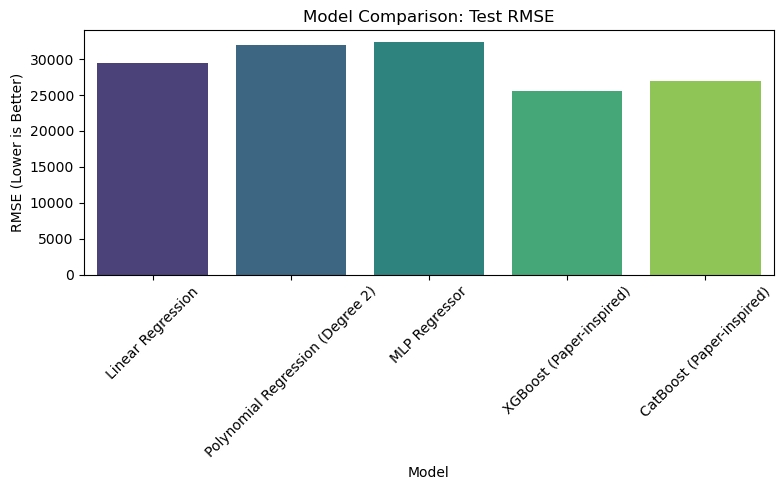

In [90]:
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_df, x="Model", y="Test_RMSE", palette="viridis")
plt.title("Model Comparison: Test RMSE")
plt.ylabel("RMSE (Lower is Better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

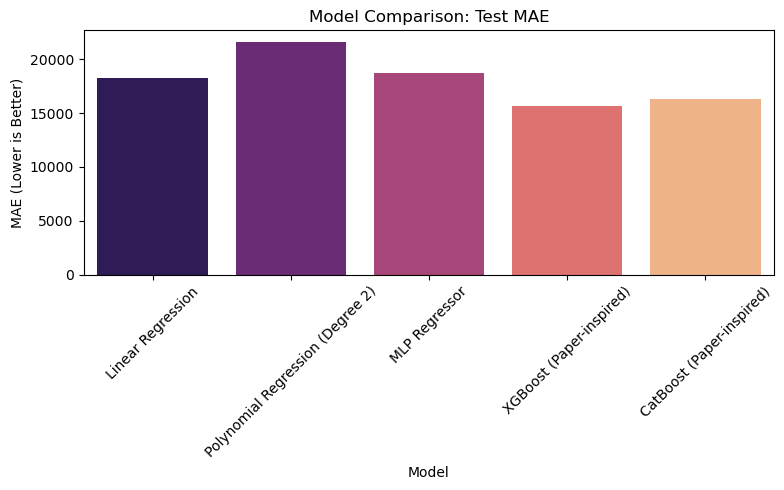

In [91]:
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_df, x="Model", y="Test_MAE", palette="magma")
plt.title("Model Comparison: Test MAE")
plt.ylabel("MAE (Lower is Better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

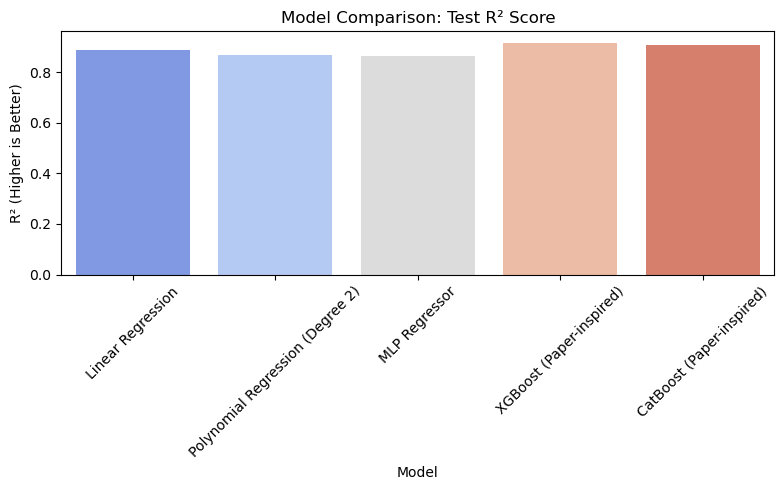

In [92]:
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_df, x="Model", y="Test_R2", palette="coolwarm")
plt.title("Model Comparison: Test R² Score")
plt.ylabel("R² (Higher is Better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

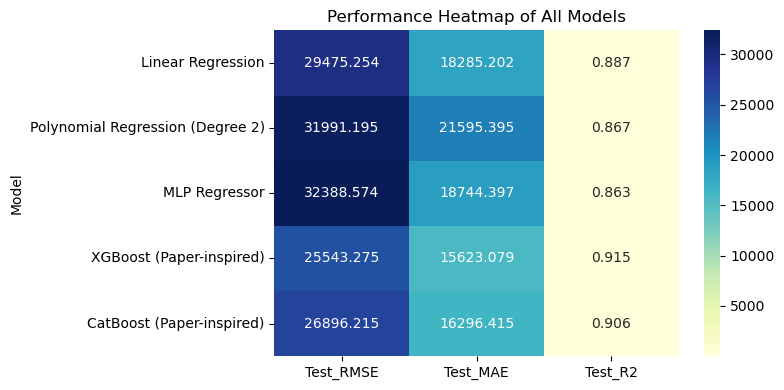

In [93]:
plt.figure(figsize=(8,4))
sns.heatmap(
    metrics_df.set_index("Model")[["Test_RMSE","Test_MAE","Test_R2"]],
    annot=True, fmt=".3f", cmap="YlGnBu"
)
plt.title("Performance Heatmap of All Models")
plt.tight_layout()
plt.show()

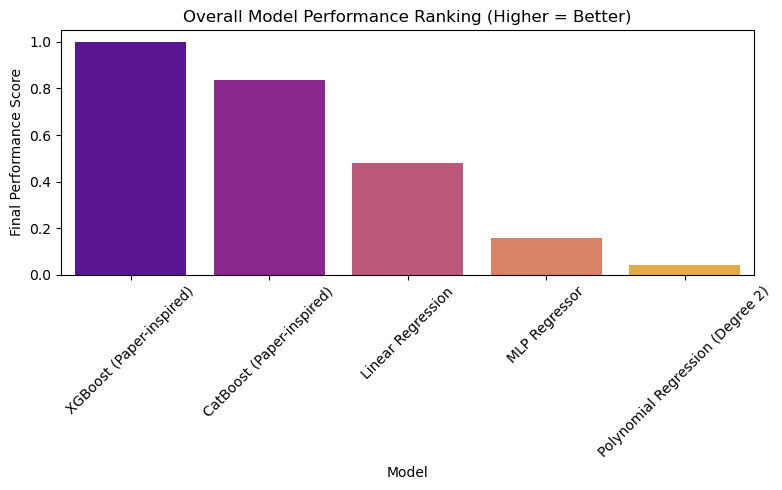

In [94]:
plt.figure(figsize=(8,5))
sns.barplot(data=rank_df.sort_values("Final_Score", ascending=False),
            x="Model", y="Final_Score", palette="plasma")

plt.title("Overall Model Performance Ranking (Higher = Better)")
plt.ylabel("Final Performance Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Classification Merics

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_classification_metrics(y_true, y_pred):
    y_true_bins = pd.qcut(y_true, q=3, labels=["Low", "Mid", "High"])
    y_pred_bins = pd.qcut(y_pred, q=3, labels=["Low", "Mid", "High"])

    accuracy = accuracy_score(y_true_bins, y_pred_bins)
    precision = precision_score(y_true_bins, y_pred_bins, average="weighted")
    recall = recall_score(y_true_bins, y_pred_bins, average="weighted")
    f1 = f1_score(y_true_bins, y_pred_bins, average="weighted")

    return accuracy, precision, recall, f1, y_true_bins, y_pred_bins


In [96]:
classification_results = []

models = [
    ("Linear Regression", y_test_pred_lin),
    ("Polynomial Regression", y_test_pred_poly),
    ("MLP", y_test_pred_mlp),
    ("XGBoost", y_test_pred_xgb),
    ("CatBoost", y_test_pred_cat)
]

for name, preds in models:
    acc, prec, rec, f1, true_bins, pred_bins = get_classification_metrics(y_test, preds)
    classification_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

In [97]:
class_df = pd.DataFrame(classification_results)
class_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Linear Regression,0.821918,0.822165,0.821918,0.822028
1,Polynomial Regression,0.770548,0.771042,0.770548,0.770782
2,MLP,0.849315,0.849880,0.849315,0.849582
3,XGBoost,0.835616,0.835616,0.835616,0.835616
4,CatBoost,0.845890,0.846243,0.845890,0.846053


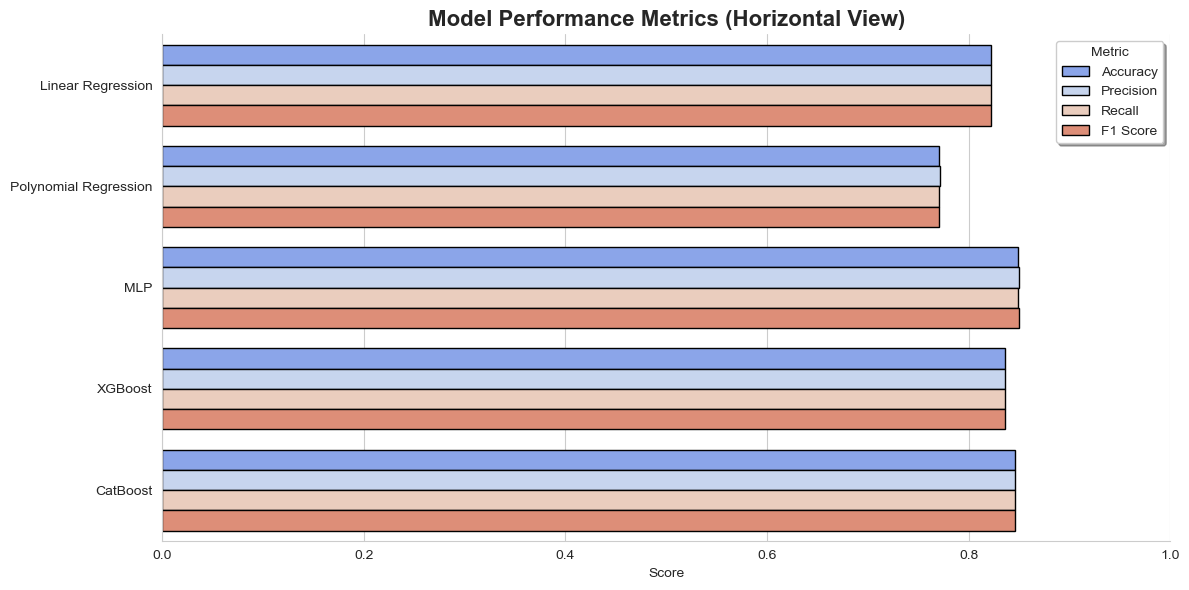

In [101]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

class_df_melt = class_df.melt(
    id_vars="Model",
    value_vars=["Accuracy", "Precision", "Recall", "F1 Score"]
)

sns.barplot(
    data=class_df_melt,
    y="Model",
    x="value",
    hue="variable",
    palette="coolwarm",
    edgecolor="black"
)

plt.title("Model Performance Metrics (Horizontal View)", fontsize=16, weight="bold")
plt.xlabel("Score")
plt.ylabel("")
plt.xlim(0, 1)

plt.legend(title="Metric", frameon=True, shadow=True)
sns.despine()
plt.tight_layout()
plt.show()

In [103]:
class_df["Overall Score"] = (
    class_df["Accuracy"] +
    class_df["Precision"] +
    class_df["Recall"] +
    class_df["F1 Score"]
) / 4

best_model = class_df.sort_values("Overall Score", ascending=False).iloc[0]

print(f"Best Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"F1 Score: {best_model['F1 Score']:.4f}")

print(f"Overall Score: {best_model['Overall Score']:.4f}")
print("This model outperformed all others based on combined metrics.")

Best Model: MLP
Accuracy: 0.8493
Precision: 0.8499
Recall: 0.8493
F1 Score: 0.8496
Overall Score: 0.8495
This model outperformed all others based on combined metrics.
